# Day 7: Week 6.1 Review - Classification Interview Prep

## 🎯 Learning Objectives
- Consolidate all classification methods
- Build comprehensive classification pipeline
- Practice interview questions
- Final trading strategy comparison

---

## 📚 Week Summary

| Day | Topic | Key Concept |
|-----|-------|-------------|
| 1 | Logistic Regression | Probabilities, thresholds, interpretability |
| 2 | SVM | Maximum margin, kernels, calibration |
| 3 | Triple-Barrier | Path-dependent labels, trading reality |
| 4 | Meta-Labeling | Signal quality, precision improvement |
| 5 | Multi-Class | BUY/HOLD/SELL, turnover reduction |
| 6 | Class Imbalance | SMOTE, weights, threshold tuning |

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix,
                             roc_auc_score)
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
ticker = 'AAPL'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days")

📥 Downloading data...
✅ Data: 1256 days


In [2]:
# Comprehensive Feature Engineering
df = pd.DataFrame(index=prices.index)
df['price'] = prices
df['return'] = returns

# Momentum
for lag in [1, 5, 10, 20, 60]:
    df[f'momentum_{lag}'] = prices.pct_change(lag)

# Volatility
for window in [5, 10, 20]:
    df[f'volatility_{window}'] = returns.rolling(window).std()

# Moving Averages
df['ma_5_20'] = prices.rolling(5).mean() / prices.rolling(20).mean() - 1
df['ma_20_50'] = prices.rolling(20).mean() / prices.rolling(50).mean() - 1

# RSI
delta = prices.diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
df['rsi'] = 100 - (100 / (1 + gain / loss))

# MACD
ema_12 = prices.ewm(span=12).mean()
ema_26 = prices.ewm(span=26).mean()
df['macd'] = (ema_12 - ema_26) / prices

# Target: Binary classification
df['next_return'] = returns.shift(-1)
df['target'] = (df['next_return'] > 0).astype(int)

df = df.dropna()
print(f"📊 Features: {len(df.columns)-3}, Samples: {len(df)}")

📊 Features: 13, Samples: 1195


In [3]:
# Prepare data
feature_cols = [c for c in df.columns if c not in ['price', 'return', 'next_return', 'target']]
X = df[feature_cols]
y = df['target']

# Split: 70% train, 15% val, 15% test
train_idx = int(len(df) * 0.7)
val_idx = int(len(df) * 0.85)

X_train = X.iloc[:train_idx]
X_val = X.iloc[train_idx:val_idx]
X_test = X.iloc[val_idx:]

y_train = y.iloc[:train_idx]
y_val = y.iloc[train_idx:val_idx]
y_test = y.iloc[val_idx:]

returns_test = df['next_return'].iloc[val_idx:]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 836, Val: 179, Test: 180


In [4]:
# Train all classifiers
classifiers = {
    'Logistic': LogisticRegression(max_iter=1000, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
}

print("\n" + "="*60)
print("TRAINING CLASSIFIERS")
print("="*60)

for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train)
    print(f"✅ {name} trained")


TRAINING CLASSIFIERS
✅ Logistic trained
✅ SVM (RBF) trained


✅ Random Forest trained
✅ Gradient Boosting trained


In [5]:
# Validation set performance (model selection)
print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE (Model Selection)")
print("="*70)

val_results = []
for name, clf in classifiers.items():
    y_pred = clf.predict(X_val_scaled)
    y_proba = clf.predict_proba(X_val_scaled)[:, 1]
    
    val_results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1': f1_score(y_val, y_pred),
        'AUC': roc_auc_score(y_val, y_proba)
    })

val_df = pd.DataFrame(val_results)
print(val_df.to_string(index=False))

best_model = val_df.loc[val_df['F1'].idxmax(), 'Model']
print(f"\n🏆 Best Model (by F1): {best_model}")


VALIDATION SET PERFORMANCE (Model Selection)
            Model  Accuracy  Precision   Recall       F1      AUC
         Logistic  0.536313   0.544828 0.822917 0.655602 0.593122
        SVM (RBF)  0.508380   0.533333 0.666667 0.592593 0.532631
    Random Forest  0.502793   0.527132 0.708333 0.604444 0.535078
Gradient Boosting  0.558659   0.584158 0.614583 0.598985 0.545306

🏆 Best Model (by F1): Logistic


In [6]:
# Test set performance (final evaluation)
print("\n" + "="*70)
print("TEST SET PERFORMANCE (Final Evaluation)")
print("="*70)

test_results = []
test_predictions = {}
test_probabilities = {}

for name, clf in classifiers.items():
    y_pred = clf.predict(X_test_scaled)
    y_proba = clf.predict_proba(X_test_scaled)[:, 1]
    
    test_predictions[name] = y_pred
    test_probabilities[name] = y_proba
    
    test_results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba)
    })

test_df = pd.DataFrame(test_results)
print(test_df.to_string(index=False))


TEST SET PERFORMANCE (Final Evaluation)
            Model  Accuracy  Precision   Recall       F1      AUC
         Logistic  0.544444   0.542857 0.808511 0.649573 0.526843
        SVM (RBF)  0.538889   0.540741 0.776596 0.637555 0.435304
    Random Forest  0.533333   0.537313 0.765957 0.631579 0.551954
Gradient Boosting  0.583333   0.592233 0.648936 0.619289 0.575272


In [7]:
# Ensemble prediction (voting)
ensemble_proba = np.mean([test_probabilities[name] for name in classifiers.keys()], axis=0)
ensemble_pred = (ensemble_proba > 0.5).astype(int)

test_predictions['Ensemble'] = ensemble_pred
test_probabilities['Ensemble'] = ensemble_proba

print("\n" + "="*60)
print("ENSEMBLE MODEL")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, ensemble_pred):.2%}")
print(f"F1: {f1_score(y_test, ensemble_pred):.2%}")
print(f"AUC: {roc_auc_score(y_test, ensemble_proba):.4f}")


ENSEMBLE MODEL
Accuracy: 56.11%
F1: 64.89%
AUC: 0.5787


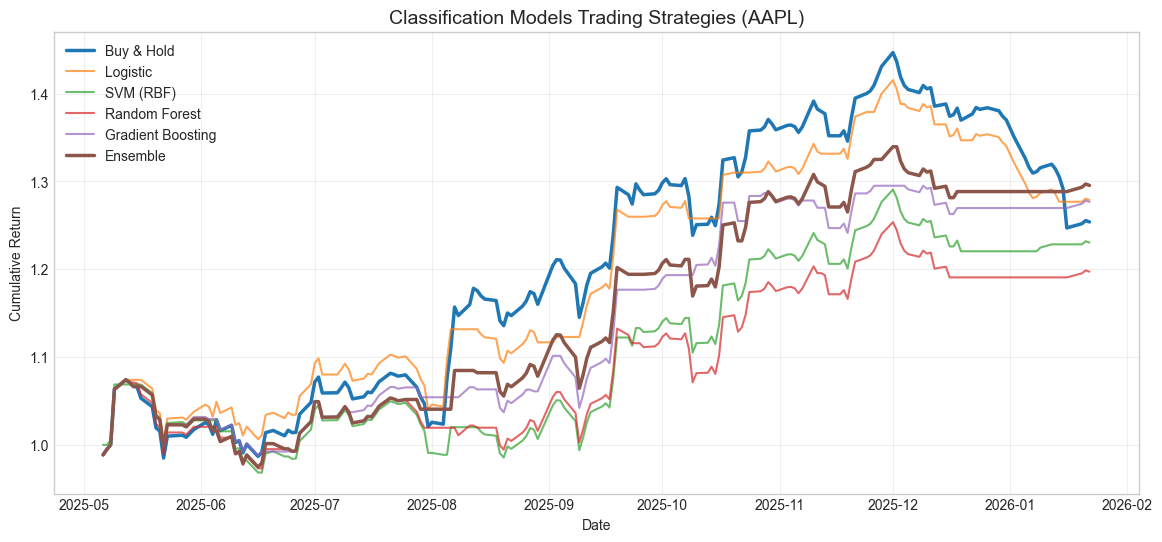

In [8]:
# Trading Strategy Backtest
backtest = pd.DataFrame(index=y_test.index)
backtest['actual_return'] = returns_test.values

# All models + ensemble
all_models = list(classifiers.keys()) + ['Ensemble']

for name in all_models:
    backtest[f'{name}_signal'] = test_predictions[name]
    backtest[f'{name}_return'] = backtest[f'{name}_signal'] * backtest['actual_return']
    backtest[f'{name}_cum'] = (1 + backtest[f'{name}_return']).cumprod()

backtest['buy_hold_cum'] = (1 + backtest['actual_return']).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2.5)
for name in all_models:
    plt.plot(backtest.index, backtest[f'{name}_cum'], label=name, 
             linewidth=2.5 if name == 'Ensemble' else 1.5,
             alpha=1.0 if name == 'Ensemble' else 0.7)
plt.title(f'Classification Models Trading Strategies ({ticker})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
# Final Performance Summary
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*70)
print("FINAL STRATEGY PERFORMANCE")
print("="*70)

print(f"\n{'Strategy':<20} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 55)

# Buy and hold
total, sharpe, mdd = calc_metrics(backtest['actual_return'], backtest['buy_hold_cum'])
print(f"{'Buy & Hold':<20} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%}")

# Models
for name in all_models:
    total, sharpe, mdd = calc_metrics(backtest[f'{name}_return'], backtest[f'{name}_cum'])
    print(f"{name:<20} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%}")


FINAL STRATEGY PERFORMANCE

Strategy                Total Ret     Sharpe     Max DD
-------------------------------------------------------
Buy & Hold                 25.38%       1.32    -13.80%
Logistic                   27.88%       1.68     -9.78%
SVM (RBF)                  23.02%       1.34     -9.39%
Random Forest              19.71%       1.17     -9.39%
Gradient Boosting          27.65%       1.79     -8.04%
Ensemble                   29.54%       1.73     -9.25%


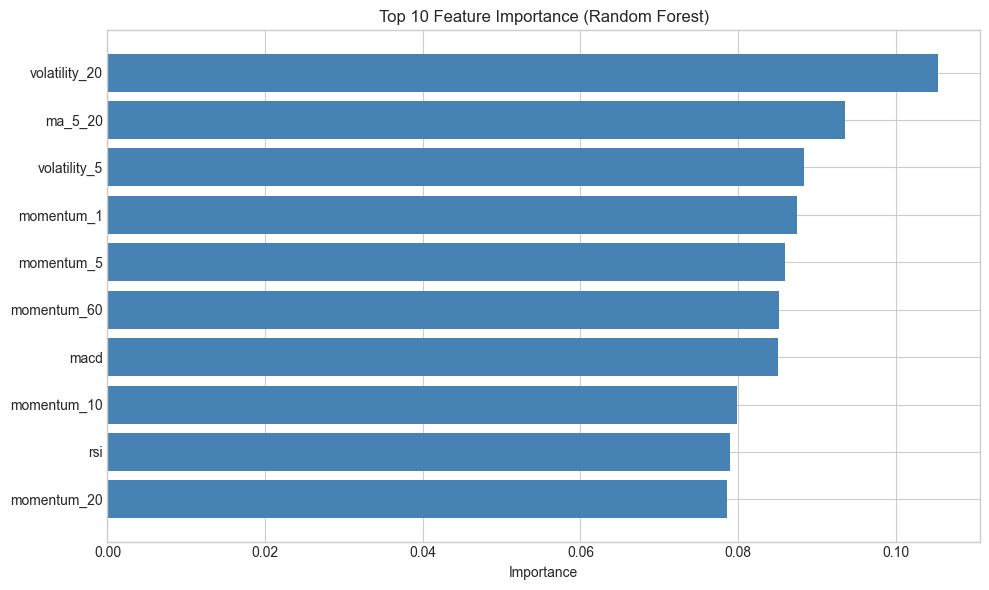

In [10]:
# Feature Importance (from Random Forest)
rf = classifiers['Random Forest']
importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'].head(10), importance['Importance'].head(10), color='steelblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [11]:
# Next Day Prediction
latest_scaled = scaler.transform(X.iloc[[-1]])

print("\n" + "="*60)
print(f"📊 NEXT DAY PREDICTIONS FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")

predictions_today = []
for name, clf in classifiers.items():
    pred = clf.predict(latest_scaled)[0]
    proba = clf.predict_proba(latest_scaled)[0, 1]
    predictions_today.append(proba)
    signal = '📈 UP' if pred == 1 else '📉 DOWN'
    print(f"{name:<20}: {signal} (Prob: {proba:.2%})")

# Ensemble
ens_proba = np.mean(predictions_today)
ens_pred = '📈 UP' if ens_proba > 0.5 else '📉 DOWN'
print(f"{'Ensemble':<20}: {ens_pred} (Prob: {ens_proba:.2%})")

# Consensus
bullish = sum(1 for p in predictions_today if p > 0.5)
print(f"\n🎯 Consensus: {bullish}/{len(predictions_today)} models bullish")


📊 NEXT DAY PREDICTIONS FOR AAPL

Date: 2026-01-22
Logistic            : 📈 UP (Prob: 52.95%)
SVM (RBF)           : 📈 UP (Prob: 51.83%)
Random Forest       : 📈 UP (Prob: 62.23%)
Gradient Boosting   : 📈 UP (Prob: 73.81%)
Ensemble            : 📈 UP (Prob: 60.20%)

🎯 Consensus: 4/4 models bullish


---

## 📝 Interview Questions & Answers

### Q1: Logistic vs SVM for trading?
**A:** Logistic gives calibrated probabilities (good for position sizing). SVM better for non-linear patterns but needs calibration for probabilities.

### Q2: What's the triple-barrier method?
**A:** Labeling method with upper (profit), lower (stop-loss), and vertical (time) barriers. Reflects trading reality better than fixed-horizon labels.

### Q3: Explain meta-labeling.
**A:** Two-model approach: primary model predicts direction, meta-model predicts if primary signal will be profitable. Separates signal generation from position sizing.

### Q4: How to handle class imbalance?
**A:** Options: class weights, undersampling (careful with time series), threshold adjustment, SMOTE (caution in finance). Use F1 or PR-AUC for evaluation.

### Q5: Why ensemble methods?
**A:** Reduce variance, combine diverse models, more robust predictions. Average probabilities or use voting.

---

## 🏢 Company Use Cases

| Company | Classification Application |
|---------|---------------------------|
| Two Sigma | Direction prediction, signal filtering |
| Citadel | Execution timing, regime classification |
| DE Shaw | Market microstructure signals |
| WorldQuant | Alpha signal quality scoring |
| Renaissance | Multi-model ensemble systems |

---

## 📅 Next Week: Tree Ensembles (Decision Trees, Random Forest, XGBoost, LightGBM)